In [1]:
# Basis:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.xgboost.html


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

import pickle

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
from darts.datasets import WeatherDataset
from darts.models import XGBModel

# from torchmetrics.regression import MeanSquaredError
# import torch
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae, mse
from darts.dataprocessing.transformers import Scaler, Diff
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

# for reproducibility
# torch.manual_seed(1)
np.random.seed(1)


In [5]:
# Loading the dataset
data = pd.DataFrame(pd.read_csv('../raw_data/hourly_final_dataset.csv'))


In [6]:
df = data
df.shape


(15312, 20)

In [7]:
df.head()


,timestamp,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
0,2021-01-01 00:00:00,-1.4,97,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 01:00:00,-0.1,97,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 02:00:00,-0.9,97,-3.9,0.0,0.0,5.1,11.2,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 03:00:00,-1.5,97,-4.7,0.0,0.0,5.6,10.3,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 04:00:00,-1.4,97,-4.5,0.0,0.0,4.8,10.0,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')


In [12]:
df.head()


,index,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday
0,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
1,2021-01-01 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
2,2021-01-01 00:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4,97.0,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1.0
3,2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0
4,2021-01-01 01:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.1,97.0,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1.0


In [9]:
ts = TimeSeries.from_dataframe(df=df,freq='60min', fill_missing_dates=True, fillna_value=0)


In [10]:
ts.columns


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday',
       'traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [15]:
# Remember to set the negative values to 0


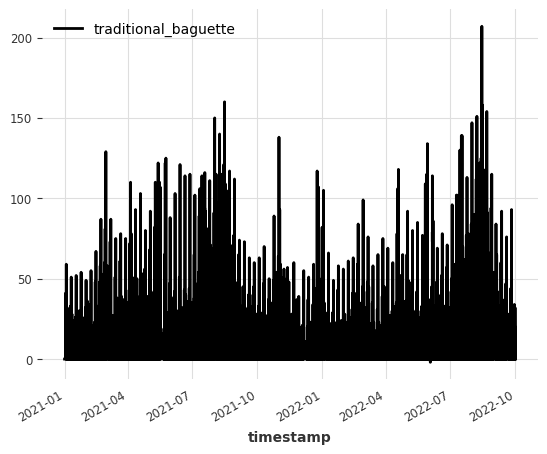

In [12]:
ts['traditional_baguette'].plot();


### Testing reverse differentiation

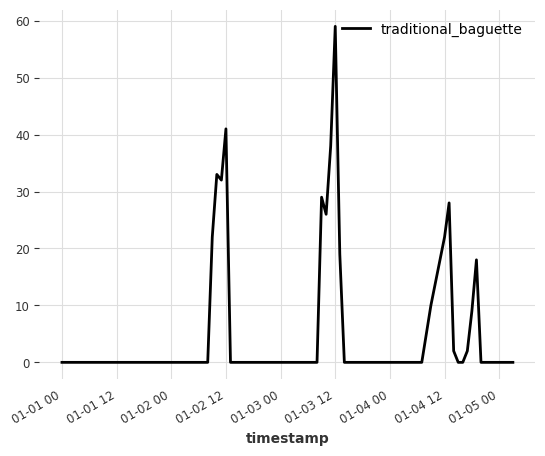

In [13]:
test_bag = ts['traditional_baguette'][:100]
test_bag.plot();


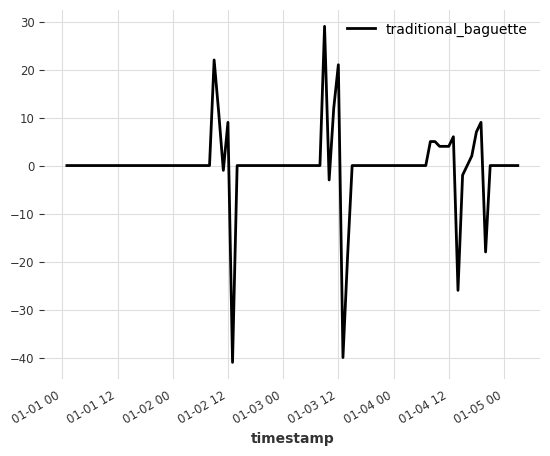

In [14]:
first_order_diff = Diff(lags=1, dropna=True, name='DifTest').fit_transform(test_bag)
first_order_diff.plot();


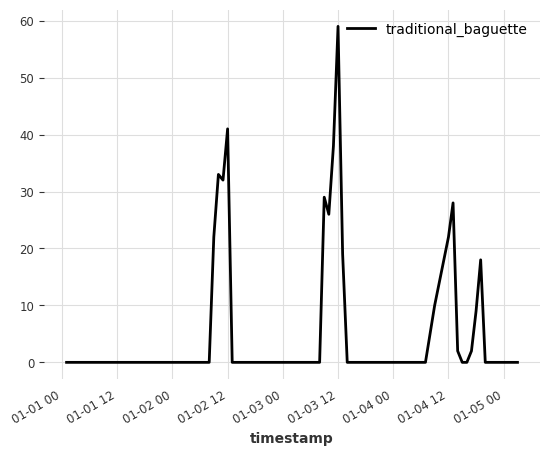

In [18]:
# For reversing the transformation
first_order_diff.cumsum().plot();


### Testing the inverse of the MinMaxScaler

In [19]:
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)


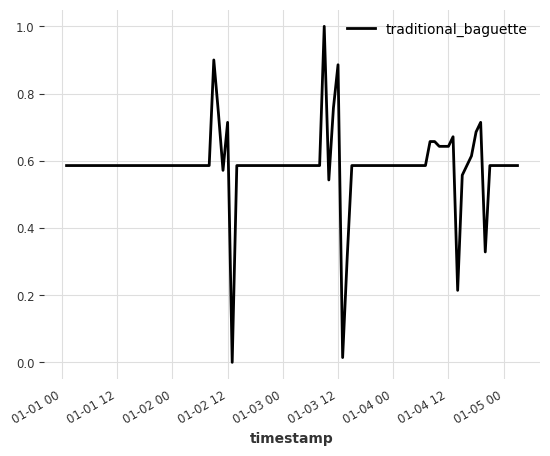

In [20]:
scaled_diff = ts_transformer.fit_transform(first_order_diff)
scaled_diff.plot();


### Preparing the dataset

In [21]:
# Differentiating
diff_ts = ts.diff()


In [22]:
# Scaling
# Instantiating the scaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)


In [23]:
scaled_ts = ts_transformer.fit_transform(diff_ts)


In [24]:
# Splitting the dataset in train and test
ts_train, ts_test = scaled_ts.split_before(0.8)


In [25]:
len(ts_train), len(ts_test)


(12248, 3063)

In [27]:
ts_train.time_index


DatetimeIndex(['2021-01-01 01:00:00', '2021-01-01 02:00:00',
               '2021-01-01 03:00:00', '2021-01-01 04:00:00',
               '2021-01-01 05:00:00', '2021-01-01 06:00:00',
               '2021-01-01 07:00:00', '2021-01-01 08:00:00',
               '2021-01-01 09:00:00', '2021-01-01 10:00:00',
               ...
               '2022-05-25 23:00:00', '2022-05-26 00:00:00',
               '2022-05-26 01:00:00', '2022-05-26 02:00:00',
               '2022-05-26 03:00:00', '2022-05-26 04:00:00',
               '2022-05-26 05:00:00', '2022-05-26 06:00:00',
               '2022-05-26 07:00:00', '2022-05-26 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=12248, freq='H')

### Defining the different datasets to feed the model

In [28]:
# Defining target lists
target = ts_train[['traditional_baguette','croissant',]][:1344]


In [29]:
future_covariates = ts_train[['temperature_2m (°C)',
                                   'relative_humidity_2m (%)',
                                   'apparent_temperature (°C)',
                                   'precipitation (mm)',
                                   'rain (mm)',
                                   'day_of_week_sin',
                                   'day_of_week_cos',
                                   'month_sin',
                                   'month_cos',
                                   'isHoliday']][:1512]


In [30]:
past_covariates = ts_train[['coupe',
                        'pain_au_chocolat',
                        'baguette',
                        'banette',
                        'cereal_baguette']][:1344]


### Model definition and training

In [31]:
# Prediction setup variables
days_predict = 7
interv_predict = days_predict*24  # 1 week 168
lags_input = 14*24   # 2 weeks 336

list_future_covariates=list(range(0,interv_predict))


In [32]:
# predict 504 unit sales values using the 12 pastmonth  values of all data, as well as the 7 days values
# corresponding to the forecasted period
model = XGBModel(
    lags=lags_input,   # 60 days back every 60 min
    lags_past_covariates=lags_input, # 60 days back every 60 min
    lags_future_covariates=list_future_covariates,  # 60 days back + 7 days ahead every hour. list_future_covariates=list(range(0,interv_predict))
    output_chunk_length=interv_predict, # 1 week ahead every 60 min
)


In [27]:

# training the model
model.fit(target, past_covariates=past_covariates, future_covariates=future_covariates)
xgb_model1 = model


### Saving and loading the model for future work

In [28]:
# Saving the model to compare the results
# pickle.dump(xgb_model1, open('../models/xgb_model1.pkl', 'wb'))


In [34]:
# Loading model to compare the results
xgb_model1 = pickle.load(open('../models/xgb_model1.pkl','rb'))


In [ ]:
# First predictions for a week
pred_ts = xgb_model1.predict(168)
pred_ts.values()


In [44]:
len(pred_ts)


168

### Plotting predictions

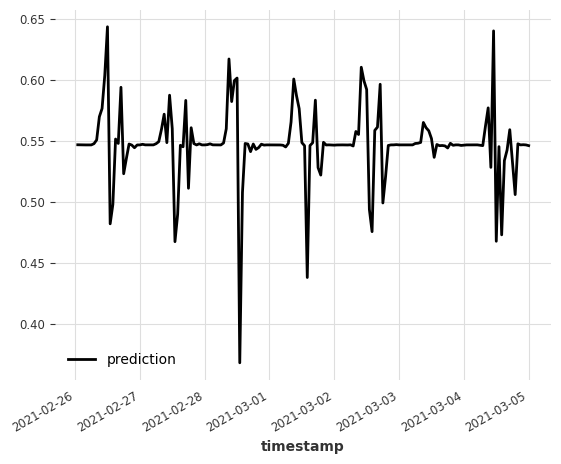

In [45]:
pred_ts['traditional_baguette'].plot(label='prediction');


In [46]:
pred_ts['traditional_baguette'][0].mean()


<TimeSeries (DataArray) (timestamp: 1, component: 1, sample: 1)>
array([[[0.5469825]]], dtype=float32)
Coordinates:
  * timestamp  (timestamp) datetime64[ns] 2021-02-26T01:00:00
  * component  (component) object 'traditional_baguette'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [47]:
pred_ts.columns


Index(['traditional_baguette', 'croissant'], dtype='object', name='component')

### Comparing predictions and actual values / Creating DataFrame with the TS

In [48]:
pred_df = pred_ts.pd_dataframe(copy=True)
pred_df.head()


component,traditional_baguette,croissant
timestamp,,
2021-02-26 01:00:00,0.546983,0.369306
2021-02-26 02:00:00,0.546913,0.368784
2021-02-26 03:00:00,0.546871,0.369099
2021-02-26 04:00:00,0.546857,0.369272
2021-02-26 05:00:00,0.546896,0.368781


In [50]:
train_df=ts_train.pd_dataframe(copy=True)
train_df[['traditional_baguette', 'croissant']].head()


component,traditional_baguette,croissant
timestamp,,
2021-01-01 01:00:00,0.546875,0.369318
2021-01-01 02:00:00,0.546875,0.369318
2021-01-01 03:00:00,0.546875,0.369318
2021-01-01 04:00:00,0.546875,0.369318
2021-01-01 05:00:00,0.546875,0.369318


In [51]:
#train_df['traditional_baguette'][pd_train.index >=2021-02-26 01:00:00]
train_df1_trad_bag = train_df.loc[(train_df.index >= '2021-02-26 01:00:00') & (train_df.index <= '2021-03-05 00:00:00')]['traditional_baguette']
train_df1_croissant = train_df.loc[(train_df.index >= '2021-02-26 01:00:00') & (train_df.index <= '2021-03-05 00:00:00')]['croissant']


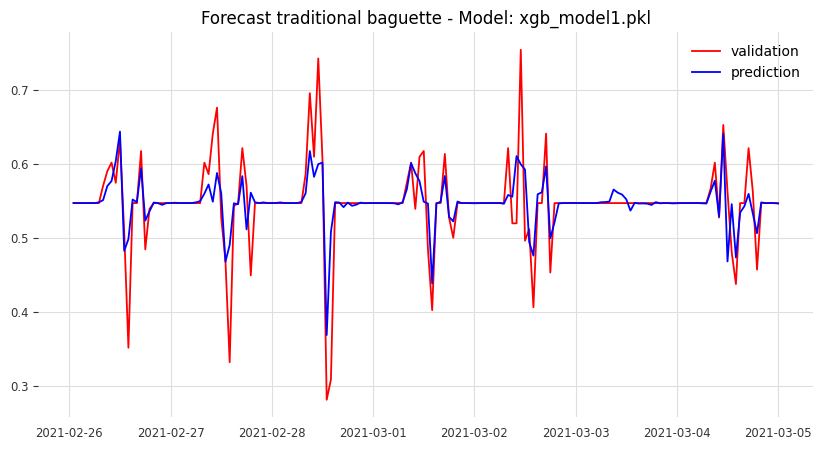

In [54]:
plt.figure(figsize=(10,5))

plt.plot(train_df1_trad_bag.index, train_df1_trad_bag.values, label='validation', c='red')
plt.plot(pred_df.index,pred_df['traditional_baguette'], label='prediction', c='blue')
plt.legend()
plt.title('Forecast traditional baguette - Model: xgb_model1.pkl')
plt.show();


In [55]:
train_df1_trad_bag.index


DatetimeIndex(['2021-02-26 01:00:00', '2021-02-26 02:00:00',
               '2021-02-26 03:00:00', '2021-02-26 04:00:00',
               '2021-02-26 05:00:00', '2021-02-26 06:00:00',
               '2021-02-26 07:00:00', '2021-02-26 08:00:00',
               '2021-02-26 09:00:00', '2021-02-26 10:00:00',
               ...
               '2021-03-04 15:00:00', '2021-03-04 16:00:00',
               '2021-03-04 17:00:00', '2021-03-04 18:00:00',
               '2021-03-04 19:00:00', '2021-03-04 20:00:00',
               '2021-03-04 21:00:00', '2021-03-04 22:00:00',
               '2021-03-04 23:00:00', '2021-03-05 00:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=168, freq='H')

In [59]:
# Dataset for calculation MSE
pred_df.rename(columns={'traditional_baguette':'pred_traditional_baguette',
                          'croissant':'pred_croissant'}, inplace=True)
df_eva = pd.concat([pred_df,train_df1_trad_bag, train_df1_trad_bag], axis=1)


In [60]:
df_eva.head()


,pred_traditional_baguette,pred_croissant,traditional_baguette,traditional_baguette
timestamp,,,,
2021-02-26 01:00:00,0.546983,0.369306,0.546875,0.546875
2021-02-26 02:00:00,0.546913,0.368784,0.546875,0.546875
2021-02-26 03:00:00,0.546871,0.369099,0.546875,0.546875
2021-02-26 04:00:00,0.546857,0.369272,0.546875,0.546875
2021-02-26 05:00:00,0.546896,0.368781,0.546875,0.546875


In [61]:
df_eva_daily = df_eva.groupby(df_eva.index.date).sum()


In [62]:
df_eva_daily.head()


,pred_traditional_baguette,pred_croissant,traditional_baguette,traditional_baguette
2021-02-26,12.692922,8.473365,12.578125,12.578125
2021-02-27,13.102043,8.887082,13.125000,13.125000
2021-02-28,13.128477,8.755833,13.125000,13.125000
2021-03-01,13.156341,8.806651,13.125000,13.125000
2021-03-02,13.183099,8.708387,13.125000,13.125000


### TESTING THE MODEL WITH VALIDATION DATA AND SAVING THE TEST DATA

In [89]:
len(ts_test)


3063

In [90]:
# Splitting the dataset in train and test
ts_val, ts_test_fin = ts_test.split_before(0.5)


In [91]:
ts_val.columns


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday',
       'traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [92]:
# Preparing data for prediction in validation dataset
# 'traditional_baguette', 'croissant'
targets_2 = ts_val[['traditional_baguette','croissant']][:336]


In [93]:
future_covariates_2 = ts_val[['temperature_2m (°C)',
                                   'relative_humidity_2m (%)',
                                   'apparent_temperature (°C)',
                                   'precipitation (mm)',
                                   'rain (mm)',
                                   'day_of_week_sin',
                                   'day_of_week_cos',
                                   'month_sin',
                                   'month_cos',
                                   'isHoliday']][:504]


In [94]:
past_covariates_2 = ts_val[['coupe',
                        'pain_au_chocolat',
                        'baguette',
                        'banette',
                        'cereal_baguette']][:336]


In [ ]:
# Prediction with validation dataset
ts_pred_2 = xgb_model1.predict(n=168,
                            series=targets_2,
                            past_covariates=past_covariates_2,
                            future_covariates=future_covariates_2,
                            predict_likelihood_parameters=False
                            )
ts_pred_2.values()


In [98]:
# Generating the evaluation ts with the actuals
ts_val_pred_2 = ts_val[['traditional_baguette','croissant']][336:504]


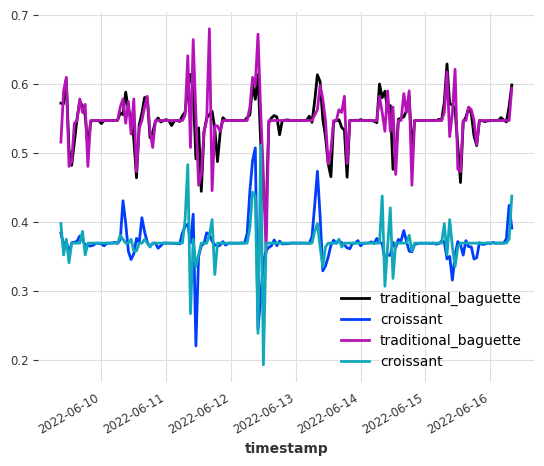

In [99]:
ts_pred_2.plot();
ts_val_pred_2.plot();


In [104]:
# Creating dataframes for evaluation
df_pred_2 = ts_pred_2.pd_dataframe(copy=True)
df_pred_2.rename(columns={'traditional_baguette':'pred_traditional_baguette', 'croissant':'pred_croissant'}, inplace=True)


In [105]:
df_val_pred_2 = ts_val_pred_2.pd_dataframe(copy=True)


In [108]:
df_eva_2 = pd.concat([df_pred_2,df_val_pred_2], axis=1)
df_eva_2.shape


(168, 4)

## Applying inverse transformations to validation data

In [146]:
# Collecting validation data from TS
ts_val_pred_2_all = ts_val[336:504]


In [147]:
# Inverse transform from Scaler
ts_val_pred_2_all= ts_transformer.inverse_transform(ts_val_pred_2_all)


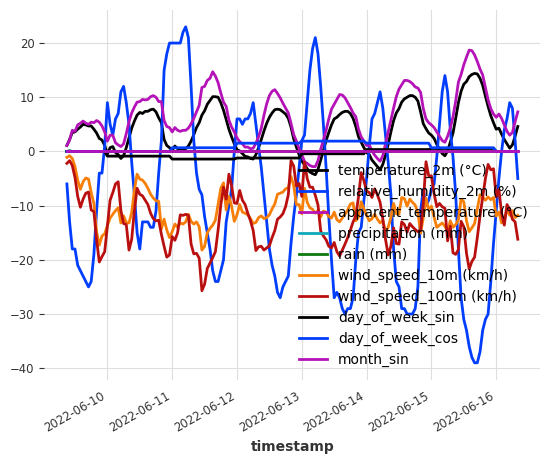

In [148]:
# Reversing differentiotion of actual data
ts_val_pred_2_all = ts_val_pred_2_all.cumsum()
ts_val_pred_2_all.plot();


In [149]:
# Passing actual data to df
df_val_pred_2_all = ts_val_pred_2_all.pd_dataframe(copy=True)


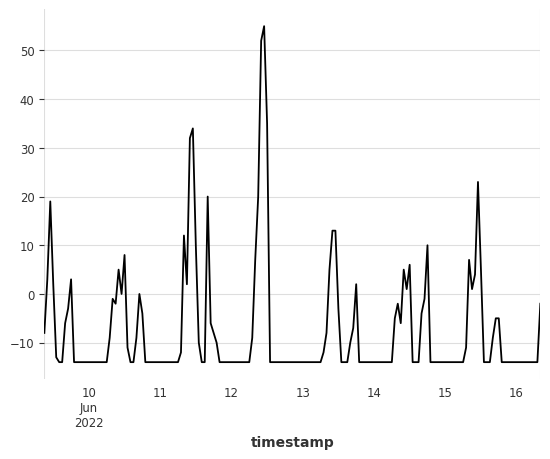

In [150]:
df_val_pred_2_all['traditional_baguette'].plot();


In [153]:

df_val_pred_2_tradbag_rev = df_val_pred_2_all['traditional_baguette']


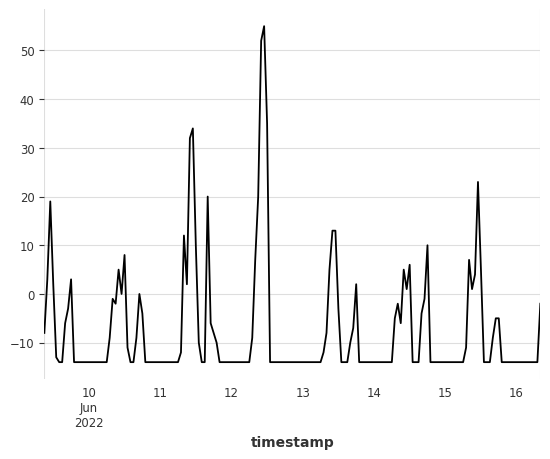

In [154]:
df_val_pred_2_tradbag_rev.plot();


## The data above has an offest of -14 units! for now I correct it quick & dirty

In [155]:
df_val_pred_2_tradbag_rev.mode()[0]


-14.0

<Axes: xlabel='timestamp'>

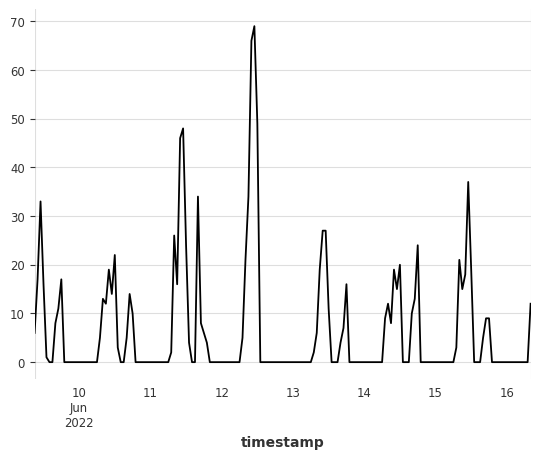

In [156]:
df_val_pred_2_tradbag = df_val_pred_2_tradbag_rev - df_val_pred_2_tradbag_rev.mode()[0]
df_val_pred_2_tradbag.plot()


### Calulating daily values

In [157]:
df_val_pred_2_tradbag_daily = df_val_pred_2_tradbag.groupby(df_val_pred_2_tradbag.index.date).sum()
df_val_pred_2_tradbag_daily


2022-06-09    109.0
2022-06-10    117.0
2022-06-11    218.0
2022-06-12    244.0
2022-06-13    119.0
2022-06-14    130.0
2022-06-15    136.0
2022-06-16     12.0
Name: traditional_baguette, dtype: float64

## Applying inverse transformation to forecasted values

In [311]:
# Collecting validation data from TS
ts_val_pred_2_all = ts_val[336:504]


In [312]:
ts_val_pred_2_all.columns


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday',
       'traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [313]:
# Deleting the columns to be replaced with the predictions
ts_pred_2_basis = ts_val_pred_2_all.drop_columns(['traditional_baguette', 'croissant'])


In [314]:
ts_pred_2_basis.components


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday', 'coupe',
       'pain_au_chocolat', 'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [315]:
# Adding the column with the predictions
ts_pred_2_all = ts_pred_2.stack(ts_pred_2_basis)


In [316]:
ts_pred_2_all.columns


Index(['traditional_baguette', 'croissant', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'apparent_temperature (°C)',
       'precipitation (mm)', 'rain (mm)', 'wind_speed_10m (km/h)',
       'wind_speed_100m (km/h)', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'isHoliday', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

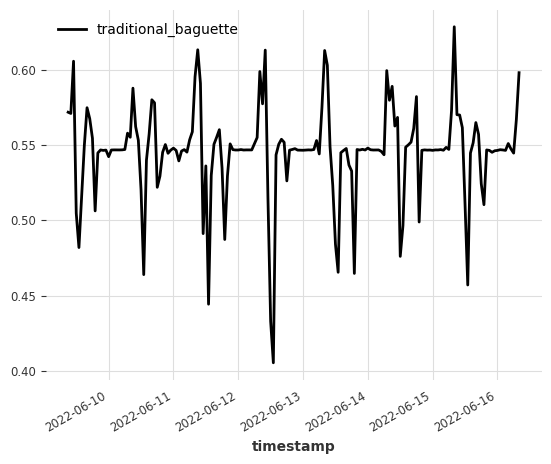

In [317]:
ts_pred_2_all[['traditional_baguette']].plot();


In [318]:
# Inverse transform from Scaler
ts_pred_2_all_desc= ts_transformer.inverse_transform(ts_pred_2_all)


In [319]:
len(ts_pred_2_all_desc)


168

<Axes: xlabel='timestamp'>

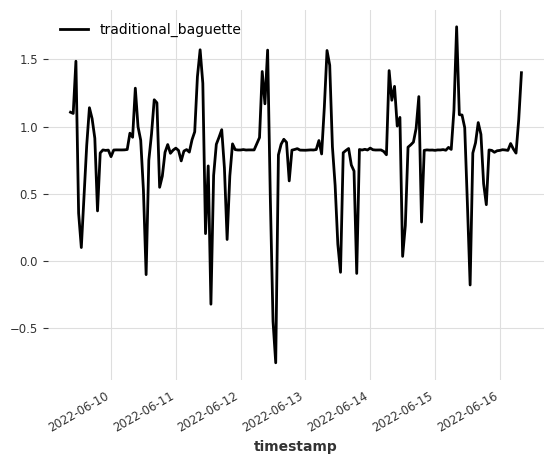

In [320]:
ts_pred_2_all_desc[['traditional_baguette']].plot()


In [321]:
# Passing actual data to df
df_pred_2_all_desc = ts_pred_2_all_desc.pd_dataframe(copy=True)


In [322]:
test3 = df_pred_2_all_desc['traditional_baguette'].apply(lambda x: np.round(x,3))


<Axes: >

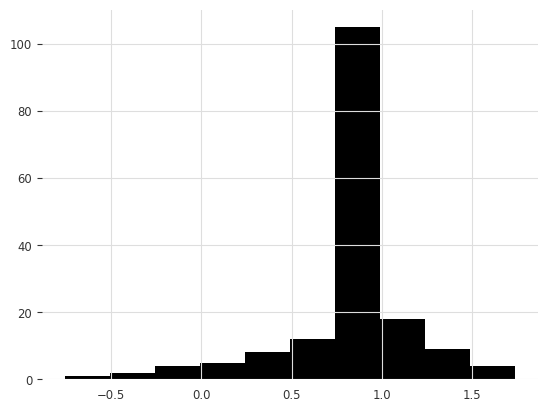

In [323]:
test3.hist()


In [324]:
test3.mode()


0    0.825
Name: traditional_baguette, dtype: float64

In [327]:
bag_offset = df_pred_2_all_desc['traditional_baguette'] - test3.mode()[0]


In [328]:
bag_rev = bag_offset.cumsum()


<Axes: xlabel='timestamp'>

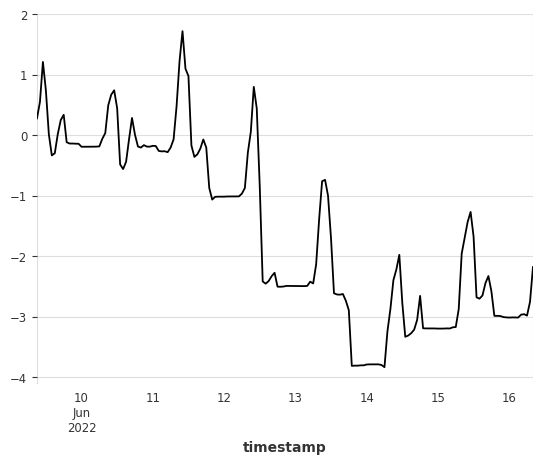

In [330]:
bag_rev.plot()


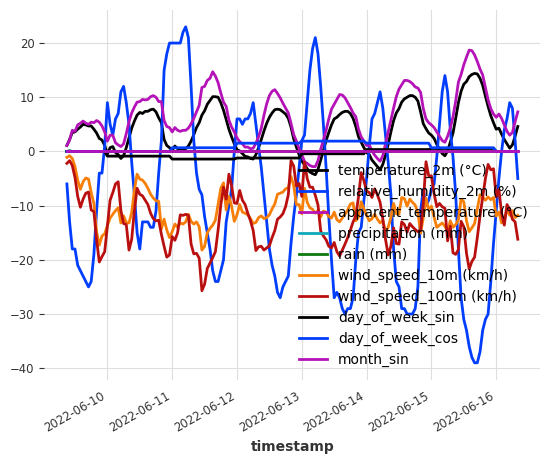

In [174]:
# Reversing differentition of data
ts_pred_2_all_pre = ts_pred_2_all_desc.cumsum()
ts_pred_2_all_pre.plot();


In [175]:
# Passing  data to df
df_pred_2_all = ts_pred_2_all_pre.pd_dataframe(copy=True)


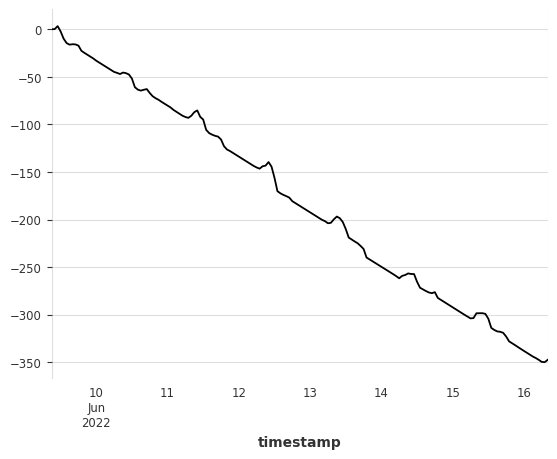

In [176]:
df_pred_2_all['traditional_baguette'].plot();


# Finding out: Issue with targets

In [18]:
data_hourly = pd.read_csv('../raw_data/hourly_final_dataset.csv')


In [25]:
data_hourly['timestamp'] = pd.to_datetime(data_hourly['timestamp'])


In [26]:
data_hourly.set_index('timestamp', inplace=True)


In [41]:
data_hourly.head()


,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-1.4,97,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-0.1,97,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-0.9,97,-3.9,0.0,0.0,5.1,11.2,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 03:00:00,-1.5,97,-4.7,0.0,0.0,5.6,10.3,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 04:00:00,-1.4,97,-4.5,0.0,0.0,4.8,10.0,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
raw_targets_hourly = data_hourly[['traditional_baguette', 'croissant']].groupby(data_hourly.index.date).sum()


In [44]:
raw_targets_hourly.index[0]


datetime.date(2021, 1, 1)

In [103]:
raw_targets_hourly[(raw_targets_hourly.index >= pd.to_datetime('2022-06-09').date())
                   & (raw_targets_hourly.index <= pd.to_datetime('2022-06-17').date())]


,traditional_baguette,croissant
2022-06-09,126.0,29.0
2022-06-10,117.0,19.0
2022-06-11,218.0,62.0
2022-06-12,244.0,87.0
2022-06-13,119.0,20.0
2022-06-14,130.0,24.0
2022-06-15,136.0,23.0
2022-06-16,115.0,23.0
2022-06-17,120.0,17.0


<Axes: >

<Figure size 2000x500 with 0 Axes>

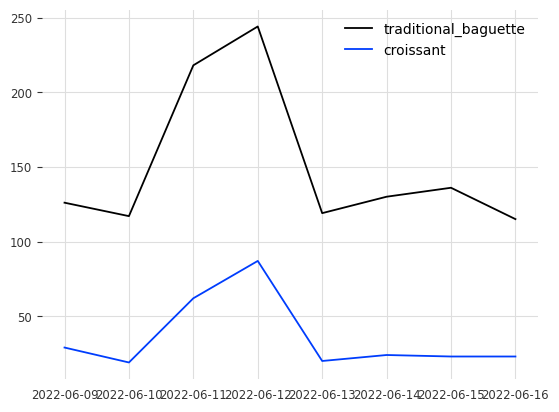

In [94]:
plt.figure(figsize=(20,5))
test_plot = raw_targets_hourly[pd.to_datetime('2022-06-09').date():pd.to_datetime('2022-06-16').date()];
test_plot.plot()


## Checking the normalized dataset

In [80]:
data_hourly.head(3)


,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),wind_speed_10m (km/h),wind_speed_100m (km/h),day_of_week_sin,day_of_week_cos,month_sin,month_cos,isHoliday,traditional_baguette,croissant,coupe,pain_au_chocolat,baguette,banette,cereal_baguette
timestamp,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-1.4,97,-4.7,0.0,0.0,6.1,11.6,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,-0.1,97,-3.2,0.0,0.0,6.1,12.9,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-01 02:00:00,-0.9,97,-3.9,0.0,0.0,5.1,11.2,-0.433884,-0.900969,0.5,0.866025,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
ts_hourly = TimeSeries.from_dataframe(df=data_hourly,freq='60min', fill_missing_dates=True, fillna_value=0)


In [89]:
ts_hourly.columns


Index(['temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'wind_speed_10m (km/h)', 'wind_speed_100m (km/h)', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'isHoliday',
       'traditional_baguette', 'croissant', 'coupe', 'pain_au_chocolat',
       'baguette', 'banette', 'cereal_baguette'],
      dtype='object', name='component')

In [90]:
# Scaling
# Instantiating the scaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)


In [91]:
scaled_ts = ts_transformer.fit_transform(ts_hourly)


In [83]:
data_hourly_scaled.


array([[0.09598214, 0.96385542, 0.14141414, ..., 0.        , 0.03921569,
        0.07142857],
       [0.125     , 0.96385542, 0.17171717, ..., 0.        , 0.03921569,
        0.07142857],
       [0.10714286, 0.96385542, 0.15757576, ..., 0.        , 0.03921569,
        0.07142857],
       ...,
       [0.45089286, 0.48192771, 0.45252525, ..., 0.        , 0.03921569,
        0.07142857],
       [0.42857143, 0.61445783, 0.43030303, ..., 0.        , 0.03921569,
        0.07142857],
       [0.41517857, 0.72289157, 0.42020202, ..., 0.        , 0.03921569,
        0.07142857]])